In [2]:
from transformers import BertConfig, RobertaForMaskedLM, RobertaTokenizer
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize
import re
from scipy.spatial.distance import cosine
from tqdm import tqdm

# drive.mount('/content/drive')

import nltk
nltk.download('punkt')

import pickle
tqdm.pandas()

c:\Users\stefa\anaconda3\envs\thesis8\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
model_path = "pdelobelle/robbert-v2-dutch-base"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
config = BertConfig.from_pretrained(model_path, output_hidden_states=True)

robbert = RobertaForMaskedLM.from_pretrained(model_path, config=config)
robbert.eval()

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(40000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [4]:

df = pd.read_csv('dfs/c1.csv',index_col = 0)

In [7]:
df = pd.read_csv('dfs/c2.csv',index_col = 0)

In [60]:
vectors = []
fails = []
for i in tqdm(range(len(df)), leave= True):
    if pd.isnull(df.iloc[i]['text_y_cleaned']):
        vectors.append(np.zeros(768))

    else:
        text = re.sub('\n', ' ', df.iloc[i]['text_y'])

        try:
            vectors.append(robbert(**tokenizer(text, return_tensors='pt', padding=True))[1][-1][:, 0].detach().numpy())

        except Exception as e:


            tokens = text.split()
            chunks = []
            texts = []

            if len(tokens) >= 200:
                n_tokens = len(tokens)
                n_chunks = int(np.ceil(n_tokens / 200))
                balance = n_tokens/n_chunks

                for j in range(n_chunks):
                    split = int(j * balance)
                    next_split = int((j+1) * balance)
                    chunks.append(tokens[split:next_split])

            for chunk in chunks:
                texts.append(' '.join([x for x in chunk]))

            try:
                vectors.append(np.mean(robbert(**tokenizer(texts, return_tensors='pt', padding=True))[1][-1][:, 0].detach().numpy(), axis = 0))

            except:
                fails.append(i)
                vectors.append(np.zeros(768))

vectors = [x.flatten() for x in vectors]
pickle.dump(vectors, open('pickles/c2_vectors.p','wb'))
pickle.dump(fails, open('pickles/c2_fails.p','wb'))

  0%|          | 25/16537 [00:21<4:14:59,  1.08it/s]

In [6]:
vectors = []
fails = []
for i in tqdm(range(len(df)), leave= True):
    if pd.isnull(df.iloc[i]['text_y_cleaned']):
        vectors.append(np.zeros(768))

    else:
        text = re.sub('\n', ' ', df.iloc[i]['text_y'])

        try:
            vectors.append(robbert(**tokenizer(text, return_tensors='pt', padding=True, truncation=True))[1][-1][:, 0].detach().numpy())

        except Exception as e:

            fails.append(i)
            vectors.append(np.zeros(768))

vectors = [x.flatten() for x in vectors]
pickle.dump(vectors, open('pickles/c1_vectors_trunc_c.p','wb'))
pickle.dump(fails, open('pickles/c1_fails_trunc_c.p','wb'))

  0%|          | 1/19102 [00:00<1:53:19,  2.81it/s]


KeyboardInterrupt: 

In [7]:
c1 = pd.read_csv('dfs/c1_old.csv',index_col = 0)
c2 = pd.read_csv('dfs/c2_old.csv',index_col = 0)

v1 = pickle.load(open('pickles/c1_vectors.p','rb'))
v2 = pickle.load(open('pickles/c2_vectors.p','rb'))

v1_trunc = pickle.load(open('pickles/c1_vectors_trunc.p','rb'))
v2_trunc = pickle.load(open('pickles/c2_vectors_trunc.p','rb'))

In [8]:
def compare(df, v):
    it = iter(range(1,len(df)))
    sims = [0]

    for i in tqdm(it):
        a = v[i]
        b = v[i-1]

        if pd.isnull(df.iloc[i]['text_y_cleaned']):
            j = i
            skips = 1
            j+=1
            sims.append(0)

            while pd.isnull(df.iloc[j]['text_y_cleaned']):
                sims.append(0)
                j+=1
                skips+=1
            
            a = v[j]

            sims.append(1-(cosine(a,b)))

            for _ in range(skips):
                i = next(it)

        else:
            sims.append(1-(cosine(a,b)))

    return sims

In [9]:
pd.set_option('display.max_rows', 1000)
c1['bert_sim'] = compare(c1, v1)
c1[['full_name','page','text_y_cleaned','bert_sim','label']].to_csv('sim_scores/bert_skip_c1.csv')

0it [00:00, ?it/s]c:\Users\stefa\anaconda3\envs\thesis8\lib\site-packages\scipy\spatial\distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
18116it [00:03, 5810.14it/s]


In [10]:
pd.set_option('display.max_rows', 1000)
c2['bert_sim'] = compare(c2, v2)
c2[['full_name','page','text_y_cleaned','bert_sim','label']].to_csv('sim_scores/bert_skip_c2.csv')

16294it [00:02, 6026.47it/s]


In [11]:
from sklearn.neural_network import MLPClassifier

clf2 = MLPClassifier(
    hidden_layer_sizes = (128,),
    batch_size = 50,
    solver = 'adam',
    verbose = 1
)

clf2.fit(v2, c2['label'])

Iteration 1, loss = 0.28491390
Iteration 2, loss = 0.23433349
Iteration 3, loss = 0.21818552
Iteration 4, loss = 0.20659018
Iteration 5, loss = 0.19953856
Iteration 6, loss = 0.18692595
Iteration 7, loss = 0.18783377
Iteration 8, loss = 0.18418299
Iteration 9, loss = 0.17129857
Iteration 10, loss = 0.16826632
Iteration 11, loss = 0.16541426
Iteration 12, loss = 0.16504572
Iteration 13, loss = 0.15698980
Iteration 14, loss = 0.15248672
Iteration 15, loss = 0.14940498
Iteration 16, loss = 0.15049046
Iteration 17, loss = 0.14886559
Iteration 18, loss = 0.14169094
Iteration 19, loss = 0.13794728
Iteration 20, loss = 0.13344064
Iteration 21, loss = 0.13111730
Iteration 22, loss = 0.12697437
Iteration 23, loss = 0.12819952
Iteration 24, loss = 0.12372083
Iteration 25, loss = 0.12201273
Iteration 26, loss = 0.11631380
Iteration 27, loss = 0.11440534
Iteration 28, loss = 0.11106603
Iteration 29, loss = 0.11064234
Iteration 30, loss = 0.11032870
Iteration 31, loss = 0.10865633
Iteration 32, los

MLPClassifier(batch_size=50, hidden_layer_sizes=(128,), verbose=1)

In [12]:
clf1 = MLPClassifier(
    hidden_layer_sizes = (128,),
    batch_size = 50,
    solver = 'adam',
    verbose = 1
)

clf1.fit(v1, c1['label'])

Iteration 1, loss = 0.39970057
Iteration 2, loss = 0.35566958
Iteration 3, loss = 0.33829834
Iteration 4, loss = 0.32052610
Iteration 5, loss = 0.32782533
Iteration 6, loss = 0.30855084
Iteration 7, loss = 0.29661655
Iteration 8, loss = 0.28572868
Iteration 9, loss = 0.27781963
Iteration 10, loss = 0.27187466
Iteration 11, loss = 0.26379269
Iteration 12, loss = 0.25832378
Iteration 13, loss = 0.25375050
Iteration 14, loss = 0.24374640
Iteration 15, loss = 0.23886669
Iteration 16, loss = 0.23181797
Iteration 17, loss = 0.22543432
Iteration 18, loss = 0.22296744
Iteration 19, loss = 0.21625912
Iteration 20, loss = 0.21498285
Iteration 21, loss = 0.20395414
Iteration 22, loss = 0.19965910
Iteration 23, loss = 0.19340577
Iteration 24, loss = 0.19073066
Iteration 25, loss = 0.18470131
Iteration 26, loss = 0.18144550
Iteration 27, loss = 0.17510053
Iteration 28, loss = 0.17735978
Iteration 29, loss = 0.21596836
Iteration 30, loss = 0.17847761
Iteration 31, loss = 0.19982902
Iteration 32, los

MLPClassifier(batch_size=50, hidden_layer_sizes=(128,), verbose=1)

In [13]:
c2['bert_proba'] = clf1.predict_proba(v2)[:,1]
c1['bert_proba'] = clf2.predict_proba(v1)[:,1]

In [16]:
def change_format(y):
    y[0] = 1
    indices = [i for i, x in enumerate(y) if x == 1]+[len(y)-1]
    result = []
    for i in range(len(indices)):
        if i != len(indices)-1:
            result.append(indices[i+1] - indices[i])
    result[-1]+=1
    return result

In [17]:
def make_index(split):
    '''Turns a doc length vector like [1,2,1,3,3,5] into a dict with pagenumbers as keys and the set of all 
    pagenumbers in the same document as value.
    This thus is an index which gives for every page its cluster.'''
    l= sum(split)
    pages= list(np.arange(l))
    out = defaultdict(set)
    for block_length in split:
        block= pages[:block_length]
        pages= pages[block_length:]
        for page in block:
            out[page]= set(block)
    return out

In [18]:
def Bcubed(truth,pred):
    assert sum(truth)==sum(pred)  # same amount of pages
    truth,pred = make_index(truth), make_index(pred)
    
    df  ={i:{'size':len(truth[i]),'P':0,'R':0,'F1':0} for i in truth}
    for i in truth:
        df[i]['P']= len(truth[i] & pred[i])/len(pred[i]) 
        df[i]['R']= len(truth[i] & pred[i])/len(truth[i])
        df[i]['F1']= (2*df[i]['P']*df[i]['R'])/(df[i]['P']+df[i]['R'])
    df= pd.DataFrame.from_dict(df, orient='index')
    df.index_name='PageNr'
    return  df


def MeanBcubed(truth,pred):
    assert sum(truth)==sum(pred)  # same amount of pages
    return Bcubed(truth,pred).mean()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict

_c1 = c1[~pd.isnull(c1['text_y_cleaned'])]
_c2 = c2[~pd.isnull(c2['text_y_cleaned'])]

# Train on c1, predict c2

### Bert Vectors only

In [15]:
X_train = v1
y_train = c1['label']
X_test = v2
y_test = c2['label']

clf = MLPClassifier(
    hidden_layer_sizes = (128,),
    batch_size = 50,
    solver = 'adam',
    verbose = 0
)

clf.fit(X_train, y_train)

true = y_test
preds = clf.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(clf.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    68.910383
P        0.625141
R        0.719308
F1       0.513387
dtype: float64


(0.4579242636746143, 0.3075836081017428, 0.36799098337559877)

### Visual + Bert_similarity i-1

In [55]:
features = ['font_diff2','crop_diff','bert_sim']

X_train = c1[features]
y_train = c1['label']
X_test = c2[features]
y_test = c2['label']

model = LogisticRegression()

model.fit(X_train, y_train)

true = y_test
preds = model.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(model.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    68.910383
P        0.460502
R        0.820065
F1       0.369308
dtype: float64


(0.4175084175084175, 0.2920395666509656, 0.3436807095343681)

### Visual + Bert_proba

In [58]:
features = ['font_diff2','crop_diff','bert_proba']

X_train = c1[features]
y_train = c1['label']
X_test = c2[features]
y_test = c2['label']

model = LogisticRegression()

model.fit(X_train, y_train)

true = y_test
preds = model.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(model.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    68.910383
P        0.621317
R        0.717870
F1       0.447542
dtype: float64


(0.3566299664911441, 0.3509185115402732, 0.3537511870845204)

# Train on c2, predict c1

### Bert vectors only

In [62]:
# features = ['font_diff2','crop_diff','text_d2v_sim_score']
X_train = v2
y_train = c2['label']
X_test = v1
y_test = c1['label']

clf = MLPClassifier(
    hidden_layer_sizes = (128,),
    batch_size = 50,
    solver = 'adam',
    verbose = 0
)

clf.fit(X_train, y_train)

true = y_test
preds = clf.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(clf.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    34.380975
P        0.654473
R        0.730418
F1       0.550707
dtype: float64


(0.5359669811320755, 0.46448645886561063, 0.49767314535997814)

### Visual + Bert_similarity i-1

In [36]:
features = ['font_diff2','crop_diff','bert_sim']

X_train = c2[features]
y_train = c2['label']
X_test = c1[features]
y_test = c1['label']

clf = LogisticRegression()

clf.fit(X_train, y_train)

true = y_test
preds = clf.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(clf.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    34.380975
P        0.220258
R        0.931222
F1       0.240076
dtype: float64


(0.36087484811664644, 0.07588145120081757, 0.12539582013932868)

### Visual + Bert_proba

In [41]:
features = ['font_diff2','crop_diff','bert_proba']

X_train = c2[features]
y_train = c2['label']
X_test = c1[features]
y_test = c1['label']

clf = LogisticRegression()

clf.fit(X_train, y_train)

true = y_test
preds = clf.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(clf.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    34.380975
P        0.337096
R        0.964473
F1       0.408648
dtype: float64


(0.8282352941176471, 0.17986714358712313, 0.29554995801847184)

In [11]:
v1_plus = [np.append(v1[i], [c1.iloc[i]['font_diff2'], c1.iloc[i]['crop_diff']]) for i in tqdm(range(len(v1)))]
v2_plus = [np.append(v2[i], [c1.iloc[i]['font_diff2'], c1.iloc[i]['crop_diff']]) for i in tqdm(range(len(v2)))]

100%|██████████| 16537/16537 [00:03<00:00, 5063.69it/s]


In [25]:
# features = ['font_diff2','crop_diff','text_d2v_sim_score']
X_train = v2_plus
y_train = c2['label']
X_test = v1_plus
y_test = c1['label']

clf = MLPClassifier(
    hidden_layer_sizes = (128,),
    batch_size = 50,
    solver = 'adam',
    verbose = 0
)

clf.fit(X_train, y_train)

true = y_test
preds = clf.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(clf.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    34.380975
P        0.768560
R        0.649223
F1       0.568055
dtype: float64


(0.49170305676855897, 0.575370464997445, 0.5302566517541795)

In [10]:
# features = ['font_diff2','crop_diff','text_d2v_sim_score']
X_train = v1_plus
y_train = c1['label']
X_test = v2_plus
y_test = c2['label']

clf = MLPClassifier(
    hidden_layer_sizes = (128,),
    batch_size = 50,
    solver = 'adam',
    verbose = 0
)

clf.fit(X_train, y_train)

true = y_test
preds = clf.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(clf.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

NameError: name 'v1_plus' is not defined

In [19]:
# features = ['font_diff2','crop_diff','text_d2v_sim_score']
X_train = v1_trunc
y_train = c1['label']
X_test = v2_trunc
y_test = c2['label']

clf = MLPClassifier(
    hidden_layer_sizes = (128,),
    batch_size = 50,
    solver = 'adam',
    verbose = 0
)

clf.fit(X_train, y_train)

true = y_test
preds = clf.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(clf.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    68.910383
P        0.597625
R        0.716711
F1       0.495238
dtype: float64


(0.40730337078651685, 0.20489872821479038, 0.2726418050767784)

In [20]:
# features = ['font_diff2','crop_diff','text_d2v_sim_score']
X_train = v2_trunc
y_train = c2['label']
X_test = v1_trunc
y_test = c1['label']

clf = MLPClassifier(
    hidden_layer_sizes = (128,),
    batch_size = 50,
    solver = 'adam',
    verbose = 0
)

clf.fit(X_train, y_train)

true = y_test
preds = clf.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(clf.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    34.380975
P        0.798517
R        0.616726
F1       0.570875
dtype: float64


(0.48612497504491914, 0.6221257026060296, 0.5457805670738541)

In [22]:
v1_plus_trunc = [np.append(v1_trunc[i], [c1.iloc[i]['font_diff2'], c1.iloc[i]['crop_diff']]) for i in tqdm(range(len(v1_trunc)))]
v2_plus_trunc = [np.append(v2_trunc[i], [c1.iloc[i]['font_diff2'], c1.iloc[i]['crop_diff']]) for i in tqdm(range(len(v2_trunc)))]

100%|██████████| 16537/16537 [00:03<00:00, 4907.12it/s]


In [23]:
# features = ['font_diff2','crop_diff','text_d2v_sim_score']
X_train = v1_plus_trunc
y_train = c1['label']
X_test = v2_plus_trunc
y_test = c2['label']

clf = MLPClassifier(
    hidden_layer_sizes = (128,),
    batch_size = 50,
    solver = 'adam',
    verbose = 0
)

clf.fit(X_train, y_train)

true = y_test
preds = clf.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(clf.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    68.910383
P        0.622936
R        0.637141
F1       0.456531
dtype: float64


(0.3352984524686809, 0.2143193593970796, 0.2614942528735632)

In [24]:
# features = ['font_diff2','crop_diff','text_d2v_sim_score']
X_train = v2_plus_trunc
y_train = c2['label']
X_test = v1_plus_trunc
y_test = c1['label']

clf = MLPClassifier(
    hidden_layer_sizes = (128,),
    batch_size = 50,
    solver = 'adam',
    verbose = 0
)

clf.fit(X_train, y_train)

true = y_test
preds = clf.predict(X_test)
vb_truth, vb_pred = change_format(y_test.values), change_format(clf.predict(X_test))
print(MeanBcubed(vb_truth,vb_pred))
precision_score(true, preds), recall_score(true, preds), f1_score(true, preds)

size    34.380975
P        0.791557
R        0.625336
F1       0.566781
dtype: float64


(0.4886924342105263, 0.6073071027082269, 0.541581225791752)

<AxesSubplot:>

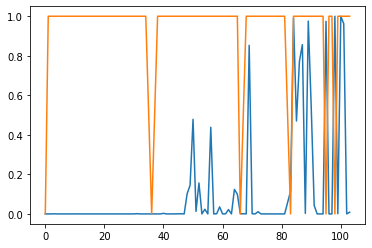

In [61]:
import matplotlib as plt

_c1['bert_proba'][:100].plot()
_c1['label'].apply(lambda x: 0 if x == 1 else 1)[:100].plot()